In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# data = pd.read_csv("linear_ramp_hw_0.csv")
data = pd.read_csv("measurements_0.csv")

# Subtract start time.
start = data.t.values[0]
data.t -= start
# To ms.
data.t /= 1000000
# data.t.values[0]
data.head()

,t,vout,code,vout_meas,vref
0,0.0000,0.000000,0.0,0.000008,4.593348
1,20.9110,0.000562,0.0,0.000337,4.595321
2,41.3439,0.001123,0.0,0.000995,4.596636
3,61.9177,0.001685,0.0,0.001652,4.593019
4,82.9650,0.002246,0.0,0.001981,4.597951


First of all, let's compute the measured input voltage using the reference voltage values.

In the most exact case, we can calculate each value separately when we know all the reference voltages during all the measurements.
However, it might also be reasonable to perform the analysis after averaging this column, since the actual end user might not monitor the reference voltage constantly during measurements.

In [19]:
res = 2 ** 10
data["vin"] = data.code * data.vref / res
data[5000:6000]

vref = np.mean(data.vref)
print(vref)

4.5979223327184116


Let's try to find the last transition

In [20]:
last_transition_v = data.vref / res * (res - 1)
print(last_transition_v)
last_transition = data[data.vout >= last_transition_v].iloc[0].name

# Keep only the data up until the last transition.
data_original = data.copy()
data = data[:last_transition]
print(len(data))

0       4.588862
1       4.590833
2       4.592147
3       4.588534
4       4.593461
          ...   
8187    4.599702
8188    4.602330
8189    4.593132
8190    4.592804
8191    4.593461
Name: vref, Length: 8192, dtype: float64
8177


## Calculate the statistics.

Coefficient = 222.70928604280806.
LinregressResult(slope=1.000927227352406, intercept=-0.00529062373810385, rvalue=0.9999949102419233, pvalue=0.0, stderr=3.5320256454621225e-05, intercept_stderr=9.363501590296047e-05)
0.004490158528045324
Offset error = 1.1767163381832515 LSB, full-scale error: 0.2299678351322473 LSB, gain error = 0.9467485030510041 LSB.


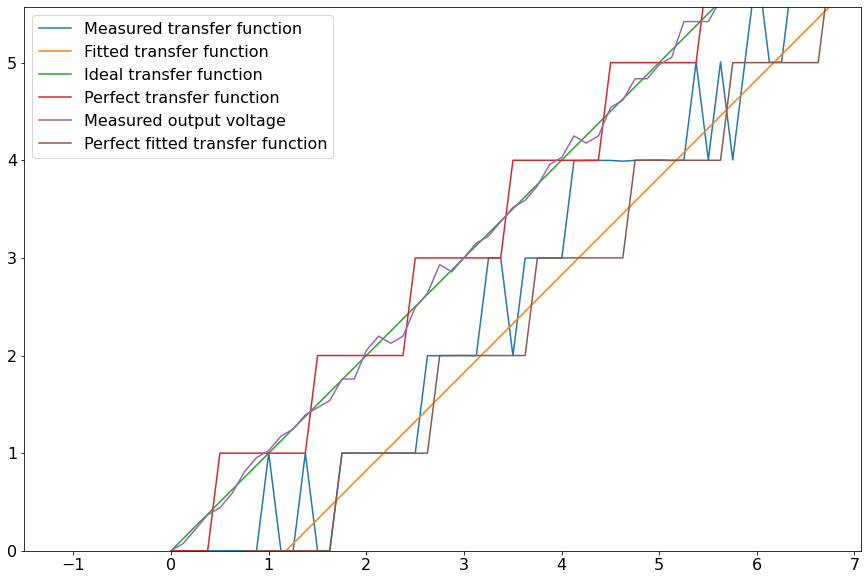

In [21]:
from scipy.stats import linregress

def v_to_code(voltage):
    global res, vref
    return voltage * res / vref

def perfect_adc_code(voltage):
    global res, vref
    return np.round(voltage * res / vref) / (res / vref)  # "/ (res / vref)" just because it will be scaled later on.

code = True
if code:
    coef = res / vref
else:
    coef = 1
print(f"Coefficient = {coef}.")


# Perform linear regression using least squares.
lr = linregress(x=data.vout, y=data.vin)
print(lr)

fig, ax = plt.subplots(figsize=(15, 10))

# print(perfect_adc_code(data.vout))
# print(v_to_code(data.vout))

ax.axis("equal")
# Plot the voltages.
limits = [0 * coef, 0.025 * coef]
# limits = [1000, 1023]
# limits = [0, 1024]
ax.plot(data.vout * coef, data.vin * coef, label="Measured transfer function")
ax.plot(data.vout * coef, (lr.slope * data.vout + lr.intercept) * coef, label="Fitted transfer function")
ax.plot(data.vout * coef, data.vout * coef, label="Ideal transfer function")
ax.plot(data.vout * coef, perfect_adc_code(data.vout) * coef, label="Perfect transfer function")
ax.plot(data.vout * coef, data.vout_meas * coef, label="Measured output voltage")
ax.plot(data.vout * coef, perfect_adc_code(lr.slope * data.vout + lr.intercept) * coef, label="Perfect fitted transfer function")

# Set the limits to display only a part of the plot.
ax.set_xlim(limits)
ax.set_ylim(limits)

# Set the legend.
ax.legend()

# Calculate offset and gain errors.
lsb_v = vref / res
print(lsb_v)

def calculate_fit_error(lsbs, lsb_v, slope, intercept, verbose=False):
    offset_y = lsbs * lsb_v
    ideal_x = offset_y
    offset_x = (offset_y - intercept) / slope
    if verbose:
        print(f"Offset_x: {offset_x * coef}, offset_y (==ideal_x): {offset_y}.")
    return offset_x - ideal_x

# Offset error calculated at 0.5 LSB.
offset_error_v = calculate_fit_error(0.5, lsb_v, lr.slope, lr.intercept)
# Full-scale error calculated at MAX - 1.5 LSB.
fs_error_v = calculate_fit_error(res - 1.5, lsb_v, lr.slope, lr.intercept)
# Gain error
gain_error_v = -(fs_error_v - offset_error_v)

offset_error = offset_error_v * coef
fs_error = fs_error_v * coef
gain_error = gain_error_v * coef
print(f"Offset error = {offset_error} LSB, full-scale error: {fs_error} LSB, gain error = {gain_error} LSB.")

# plt.show()
# plt.savefig("errors.pdf")

In [22]:
# Missing codes?
print(data.code.astype("category").unique())

# Since finding the DNL is done using the best-fit line, calculate the perfect codes based on that.
# Also take into account the actual output values (vout_meas).
# Also, do not output negative codes!
data["perfect_code"] = (np.maximum(np.round(perfect_adc_code(lr.slope * data.vout_meas + lr.intercept) * (res / vref)), 0)).astype(int)
data.perfect_code

[0.0, 1.0, 2.0, 3.0, 4.0, ..., 1019.0, 1020.0, 1021.0, 1022.0, 1023.0]
Length: 1023
Categories (1023, float64): [0.0, 1.0, 2.0, 3.0, ..., 1020.0, 1021.0, 1022.0, 1023.0]


C:\Users\Jyri\anaconda3\envs\DAQSP\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


0          0
1          0
2          0
3          0
4          0
        ... 
8172    1022
8173    1022
8174    1022
8175    1022
8176    1022
Name: perfect_code, Length: 8177, dtype: int32

## Histogram testing

Use histogram testing to find the DNL and INL.

The DNL is the ratio between the actual and theoretical counts of bins of codes minus one. A subtraction by one is done because the ideal code width is 1 and correspondingly a 1:1 ratio would be considered ideal. So for example, if the code 512 was supposed to be present 4 times and it was actually present 2 times, then the DNL would be 2 / 4 - 1 = -0.5 LSB.

To calculate the INL, we need to sum up all the DNLs leading up to a particular index (and the current DNL). So if we want the DNL of the third code, we need to sum the DNLs of the first, second, and third code. As an example, if the DNLs were -1, 0, 1, then the INL of the third code would be -1 + 0 + 1 = 0. An ideal value is 0.

(array([14.,  8.,  8., ...,  8.,  8., 15.]), array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.022e+03, 1.023e+03,
       1.024e+03]), <BarContainer object of 1024 artists>)


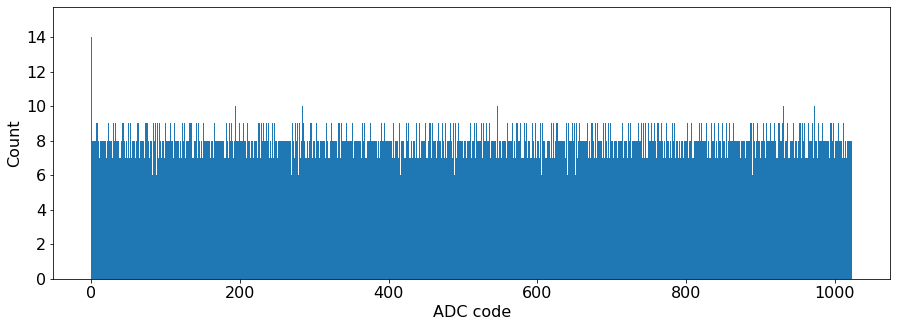

In [23]:
perfect_codes = (np.maximum(np.round(perfect_adc_code(lr.slope * data_original.vout_meas + lr.intercept) * (res / vref)), 0)).astype(int)

plt.figure(figsize=(15, 5))
perfect_hist = plt.hist(perfect_codes, bins=1024, range=(0, 1024))
plt.xlabel("ADC code")
plt.ylabel("Count")

print(perfect_hist)

(array([12.,  9.,  6., ...,  8.,  6., 13.]), array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.022e+03, 1.023e+03,
       1.024e+03]), <BarContainer object of 1024 artists>)


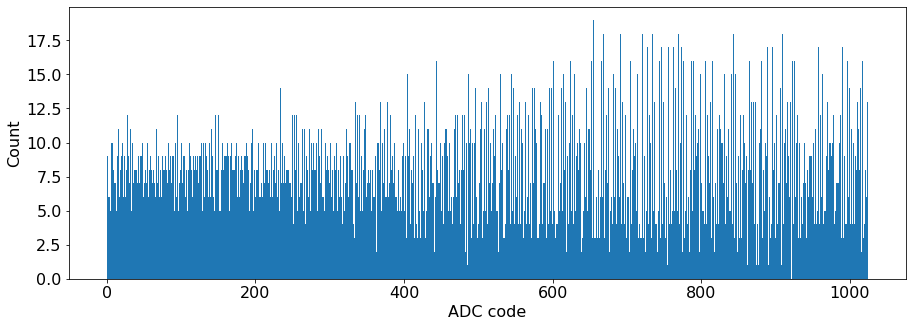

In [24]:
plt.figure(figsize=(15, 5))
real_hist = plt.hist(data_original.code.astype(int), bins=1024, range=(0, 1024))
plt.xlabel("ADC code")
plt.ylabel("Count")

print(real_hist)


In [25]:
dnls = real_hist[0] / perfect_hist[0] - 1

print(real_hist[0][1023], perfect_hist[0][1023])

print(dnls)
dnl = np.nanmax(np.abs(dnls[np.isfinite(dnls)]))
print(np.nanmin(dnls), np.nanmax(dnls))
print(np.nanargmin(dnls), np.nanargmax(dnls))

print(f"Differential non-linearity: {round(dnl, 2)} LSB.")

13.0 15.0
[-0.14285714  0.125      -0.25       ...  0.         -0.25
 -0.13333333]
-1.0 1.8333333333333335
921 889
Differential non-linearity: 1.83 LSB.


In [26]:
# Calculate integral non-linearities.
print(len(dnls))
inls = np.zeros_like(dnls)
for i in range(len(dnls)):
    inls[i] = np.sum(dnls[:i + 1])

print(inls)
inl = np.nanmax(np.abs(inls[np.isfinite(inls)]))
print(np.nanmin(inls), np.nanmax(inls))
print(np.nanargmin(inls), np.nanargmax(inls))
print(f"Integral non-linearity: {round(inl, 2)} LSB.")

1024
[-0.14285714 -0.01785714 -0.26785714 ... 13.0015873  12.7515873
 12.61825397]
-0.5178571428571429 13.537301587301585
3 1014
Integral non-linearity: 13.54 LSB.


In [27]:
# Print out all the errors found so far.
print(
f"""Offset error = {round(offset_error, 2)} LSB, 
Full-scale error: {round(fs_error, 2)} LSB, 
Gain error = {round(gain_error, 2)} LSB,
Differential non-linearity = {round(dnl, 2)} LSB,
Integral non-linearity = {round(inl, 2)} LSB."""
)


Offset error = 1.18 LSB, 
Full-scale error: 0.23 LSB, 
Gain error = 0.95 LSB,
Differential non-linearity = 1.83 LSB,
Integral non-linearity = 13.54 LSB.


Now, also create plots of DNL and INL.

In [28]:
def plot(x=[], y=[], xlabel="", ylabel="", legend="", figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    if len(x) > 0:
        ax.plot(x, y, label=legend)
    else:
        ax.plot(y, label=legend)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

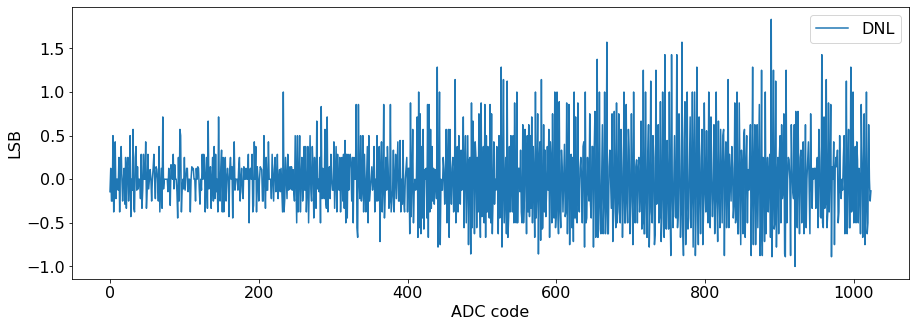

In [29]:
plt.rc("font", size=16)

plot(y=dnls, xlabel="ADC code", ylabel="LSB", legend="DNL")

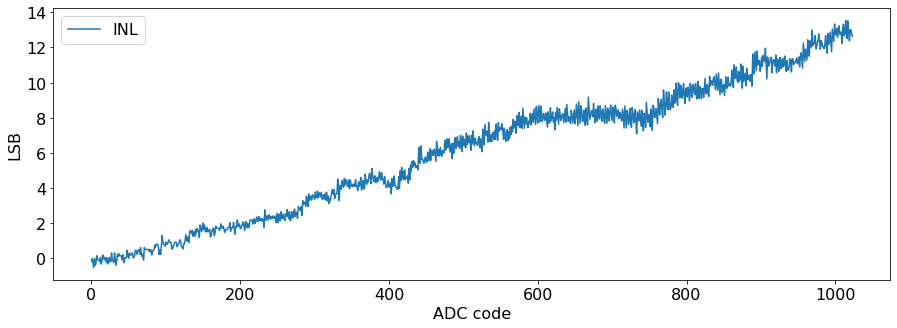

In [30]:
plot(y=inls, xlabel="ADC code", ylabel="LSB", legend="INL")